In [28]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from gymnasium import Env

MAX_MISSILES = 15

"""
The point class doesn't create missiles, it creates an attack, defense, or target point (these are in turn used to create missiles).
"""

# Set a random seed for reproducibility
random.seed(0)

class Point: 
    def __init__(self, type):
        self.type = type
        self.coordinates = np.array([0, 0])
        self.radius = 0.2

    def create_target(self):
        x = random.uniform(-3.0, 3.0)
        y = random.uniform(-2.0, 2.0)
        self.coordinates = np.array([x, y])
        self.theta = 0 # -------------------- DON'T SEE WHERE THIS IS USED
        return self.coordinates, self.theta # ----------------- DON'T SEE HOW THETA IS USED
    
    def create_defense(self, target):
        x = random.uniform((target.coordinates[0] - self.radius) - 1.5, (target.coordinates[0] + self.radius) + 1.5)
        y = random.uniform((target.coordinates[1] - self.radius) - 1.5, (target.coordinates[1] + self.radius) + 1.5)
        self.coordinates = np.array([x, y])
        return self.coordinates

    def create_attack(self, target):
        x_side_left = random.uniform(-9.5, (target.coordinates[0] - self.radius) - 2)
        x_side_right = random.uniform((target.coordinates[0] + self.radius) + 2, 9.5)
        y_below = random.uniform((target.coordinates[1] - self.radius) - 2, -9.5)
        y_above = random.uniform((target.coordinates[1] + self.radius) + 2, 9.5)
        x_inclusive = random.uniform(-9.5, 9.5)
        y_inclusive = random.uniform(-9.5, 9.5)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.coordinates = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])
        
        # Create attack_theta, .attack_theta_rad allows us to aim towards the target
        self.AT_abs_length = math.hypot(self.coordinates[0] - target.coordinates[0], self.coordinates[1] - target.coordinates[1])
        self.length_adjacent_r = abs(target.coordinates[0] - self.coordinates[0])
        self.attack_theta_rad = math.acos(self.length_adjacent_r / self.AT_abs_length)

        if self.coordinates[0] < target.coordinates[0]:
            if self.coordinates[1] < target.coordinates[1]:
                self.attack_theta_rad = self.attack_theta_rad
            else:
                self.attack_theta_rad = ((2 * math.pi) - self.attack_theta_rad)
            
        else:
            if self.coordinates[1] < target.coordinates[1]:
                self.attack_theta_rad = ((math.pi) - self.attack_theta_rad)
            else:
                self.attack_theta_rad = ((math.pi) + self.attack_theta_rad)

        return self.coordinates, self.attack_theta_rad

class Missile:
    def __init__(self, type):
        self.type = type
        self.coordinates = np.array([0, 0])
        self.radius = 0.2 # ----------------- I THINK THIS IS SPECIFIED IN THE POINT CLASS
    
    # Not sure this code is being used to create missiles, or the version specified below
    def fire_attack_missile(self, attack):
        self.speed = 1
        self.theta = attack.attack_theta_rad
        self.coordinates = attack.coordinates
        self.fired = True
        # self.fired_time = global_time # ------------------ ALSO NOT SURE THIS IS USED

        return self.coordinates, self.theta, self.speed, self.fired
    
    # def fire_attack_missile(self, global_time):
    #     self.fired = True
    #     self.fired_time = global_time
    #     return self.fired, self.fired_time
    
    # This one as well
    def create_defense_missile(self, defense, theta):
        self.speed = 1
        self.theta = theta
        self.coordinates = defense.coordinates
        self.fired = False
        self.fired_time = 0 
        self.defense_missile_to_attack_missile = None
        self.start_distance = None
        self.reward_diff = None

    def fire_defense_missile(self, global_time):
        self.fired = True
        self.fired_time = global_time
        self.initial_position = np.array([self.coordinates[0], self.coordinates[1]])
        return self.fired, self.fired_time

class Environment(Env):
    def __init__(self):

        self.action_space = gym.spaces.Tuple((
            gym.spaces.Discrete(2),
            gym.spaces.Box(low=0, high=2*math.pi, shape=(1,), dtype=np.float32)
        ))

        # Observation space
        base_low = np.array([0, -30000, -3, -2, -4.7, -4.7, -10, -10, -10, -10, 0, -2])
        base_high = np.array([10000, 30000, 3, 2, 4.7, 4.7, 10, 10, 10, 10, 2*np.pi, 30])
        missile_low = np.array([-9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999])
        missile_high = np.array([1, 10, 10, 2*np.pi, 10000, 10000, 30, 30, 2000])

        missile_low = np.tile(missile_low, MAX_MISSILES)
        missile_high = np.tile(missile_high, MAX_MISSILES)

        low = np.concatenate((base_low, missile_low))
        high = np.concatenate((base_high, missile_high))

        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

        self.global_time = 0
        self.reward = 0
        self.done = False

        self.target = None
        self.defense = None
        self.attack = None
        self.attack_missile = None
        self.initial_defense_missile = None
        self.defense_missiles = []
        self.attack_missile_to_target = None

    def reset(self):
        self.reward = 0
        self.target = Point('target')
        self.defense = Point('defense')
        self.attack = Point('attack')

        self.target.create_target()
        self.defense.create_defense(self.target)
        self.attack.create_attack(self.target)

        self.attack_missile = Missile('attack')
        self.attack_missile.fire_attack_missile(self.attack)
        self.attack_missile_to_target = self.distance_attack_to_target(self.attack_missile)

        self.fired_defense_missiles = []

        self.initial_defense_missile = Missile('defense')
        self.initial_defense_missile.create_defense_missile(self.defense, 0)

    def local_create_defense_missile(self, defense, theta):
        defense_missile = Missile('defense')
        defense_missile.create_defense_missile(defense, theta)
        return defense_missile # ------------------- NOT SURE IF ALL OF THESE RETURNS ARE EVEN BEING USED / NECESSARY
    
    def local_fire_defense_missile(self, defense_missile):
        defense_missile.fire_defense_missile(self.global_time)
        defense_missile.start_distance = self.indv_distance_defense_to_attack(defense_missile, self.attack_missile)
        self.fired_defense_missiles.append(defense_missile)
        return defense_missile

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])

    def distance_attack_to_target(self, attack_missile):
        self.attack_missile_to_target = (self.calculate_distance(attack_missile.coordinates, self.target.coordinates) - (attack_missile.radius + self.target.radius))
        if self.attack_missile_to_target < 0:
            self.reward += -100 # OJO QUE ESTA MIERDA ESTÁ SUMANDO DOS VECES ------------------
        else:
            self.reward += (-2 * (1 / self.attack_missile_to_target))

        return self.attack_missile_to_target

    def indv_distance_defense_to_attack(self, missile, attack_missile):
        missile.defense_missile_to_attack_missile = (self.calculate_distance(missile.coordinates, attack_missile.coordinates) - (missile.radius + attack_missile.radius))
        return missile.defense_missile_to_attack_missile

    def distance_defense_to_attack(self, attack_missile):
        for missile in self.fired_defense_missiles:
            missile.defense_missile_to_attack_missile = (self.calculate_distance(missile.coordinates, attack_missile.coordinates) - (missile.radius + attack_missile.radius))

    def update_attack_missile_position(self, attack_missile):
        new_coordx = self.attack.coordinates[0] + self.attack_missile.speed * self.global_time * math.cos(self.attack_missile.theta)
        new_coordy = self.attack.coordinates[1] + self.attack_missile.speed * self.global_time * math.sin(self.attack_missile.theta)
        attack_missile.coordinates = np.array([new_coordx, new_coordy]) # ---------------- THIS IS MORE SLOP, YOU EITHER CHANGE ONE OR THE OTHER, BUT NOT BOTH
        self.attack_missile.coordinates = np.array([new_coordx, new_coordy])
    
    def update_defense_missile_positions(self):
        for missile in self.fired_defense_missiles:
            new_coordx = missile.initial_position[0] + missile.speed * (self.global_time - missile.fired_time) * math.cos(missile.theta)
            new_coordy = missile.initial_position[1] + missile.speed * (self.global_time - missile.fired_time) * math.sin(missile.theta)
            missile.coordinates = np.array([new_coordx, new_coordy])

    def distance_reward(self):
        # print("REWARD ENTRANDO A DISTANCE REWARD", self.reward)
        if len(self.fired_defense_missiles) > 0:
            # print("IF ACTIVADO REWARD ENTRANDO A DISTANCE REWARD", self.reward)
            payment_ponderations = [1, 0.9, 0.85, 0.75, 0.65, 0.55, 0.35, 0.25, 0.15, 0.05] 
            max_index = len(payment_ponderations) - 1 # ----------------- THIS ALSO LOOKS LIKE SLOP, BUT I GUESS IT'S LIKE THIS IN CASE THE PONDERATIONS (NUMBER OF PONDERATED MISSILES) CHANGE

            for i, missile in enumerate(self.fired_defense_missiles):
                missile.reward_diff = missile.start_distance - missile.defense_missile_to_attack_missile

                if missile.reward_diff > 0:
                    ponderation = payment_ponderations[i] if i <= max_index else 0
                    missile.reward_diff *= ponderation

                # print("SUMANDITO EN EL FOR IF ACTIVADO REWARD ENTRANDO A DISTANCE REWARD", self.reward)
                self.reward += missile.reward_diff 
        else:
            # print("ELSE ACTIVADO REWARD ENTRANDO A DISTANCE REWARD", self.reward)
            self.reward = self.reward
            # print("SELF.REWARD DESPUES DE PUTO", self.reward)

    def check_impact(self):
        if self.attack_missile_to_target < 0:
            return -1000, True

        for missile in self.fired_defense_missiles:
            if missile.defense_missile_to_attack_missile < 0:
                return 1000, True
            
        else:
            return 0, False

    def get_state(self):

        if len(self.fired_defense_missiles) > 15:
            self.fired_defense_missiles = self.fired_defense_missiles[:15]

        base_state = np.array(
            [
                self.global_time,
                self.reward,
                self.target.coordinates[0],
                self.target.coordinates[1],
                self.defense.coordinates[0],
                self.defense.coordinates[1],
                self.attack.coordinates[0],
                self.attack.coordinates[1],
                self.attack_missile.coordinates[0],
                self.attack_missile.coordinates[1],
                self.attack_missile.theta,
                self.attack_missile_to_target
            ]
        )

        for missile in self.fired_defense_missiles:
            fired_missile_state = np.array(
                [
                    1,
                    missile.coordinates[0],
                    missile.coordinates[1],
                    missile.theta,
                    missile.fired_time,
                    self.global_time - missile.fired_time,
                    missile.start_distance,
                    missile.defense_missile_to_attack_missile,
                    missile.reward_diff
                ]
            )

            base_state = np.concatenate((base_state, fired_missile_state))

        empty_missile = np.array([
            -9999,
            -9999,
            -9999,
            -9999, 
            -9999,
            -9999,
            -9999,
            -9999,
            -9999,
        ])

        # Padding for consistency
        missiles_to_add = MAX_MISSILES - len(self.fired_defense_missiles)
        if missiles_to_add > 0:
            empty_missiles = np.tile(empty_missile, (missiles_to_add, 1)).flatten()
            base_state = np.concatenate((base_state, empty_missiles))

        return base_state        

    def step(self, action):
        fire, theta = action

        print("FIRE", fire)
        print("THETA", theta)

        self.update_attack_missile_position(self.attack_missile)
        self.distance_attack_to_target(self.attack_missile)

        if len(self.fired_defense_missiles) > 0:
            self.update_defense_missile_positions()
            self.distance_defense_to_attack(self.attack_missile) 

        if fire and len(self.defense_missiles) < MAX_MISSILES:
            defense_missile = self.local_create_defense_missile(self.defense, theta)
            self.local_fire_defense_missile(defense_missile)

        self.distance_reward()
        impact_reward, self.done = self.check_impact()

        self.reward += impact_reward

        self.global_time += 0.2

        state = self.get_state()

        # Render the environment
        self.render()

        truncated = False

        return state, self.reward, self.done, truncated, {}

    def render(self):
        fig, ax = plt.subplots()
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axhline(0, color='black', linewidth=0.5)
        plt.grid(True)

        target = Circle((self.target.coordinates[0], self.target.coordinates[1]), self.target.radius, edgecolor='red', facecolor='none', linewidth=2)       
        attack_missile = Circle((self.attack_missile.coordinates[0], self.attack_missile.coordinates[1]), self.attack_missile.radius, edgecolor='black', facecolor='none', linewidth=2) 
        plt.scatter(self.defense.coordinates[0], self.defense.coordinates[1], color='blue')
        plt.scatter(self.attack.coordinates[0], self.attack.coordinates[1], color='black')
        
        ax.add_artist(target)
        ax.add_artist(attack_missile)
        
        for missile in self.fired_defense_missiles:
            missile = Circle((missile.coordinates[0], missile.coordinates[1]), missile.radius, edgecolor='blue', facecolor='none', linewidth=2)
            ax.add_artist(missile)

        ax.set_aspect('equal')  
        plt.show()
        

--//--//--//--//--//--//--//--//--//--//--//--//--//--//--//--//
TARGET COORDINATES [ 2.02469036 -1.47791299]
DEFENSE COORDINATES [0.37476994 0.05054862]
ATTACK COORDINATES [ 9.12464821 -3.76111827]
ATTACK MISSILE COORDINATES [ 9.12464821 -3.76111827]
ATTACK MISSILE THETA 2.830457024577341
ATTACK MISSILE SPEED 1
ATTACK MISSILE FIRED True
DEFENSE MISSILES []
INITIAL DEFENSE MISSILE COORDINATES [0.37476994 0.05054862]
INITIAL DEFENSE MISSILE THETA 0
INITIAL DEFENSE MISSILE SPEED 1
INITIAL DEFENSE MISSILE FIRED False
INITIAL DEFENSE MISSILE FIRED TIME 0
INITIAL DEFENSE MISSILE DEFENSE MISSILE TO ATTACK MISSILE None
INITIAL DEFENSE MISSILE START DISTANCE None
INITIAL DEFENSE MISSILE REWARD DIFF None
ATTACK MISSILE TO TARGET 7.058044500505629
FIRE 1
THETA 0.5


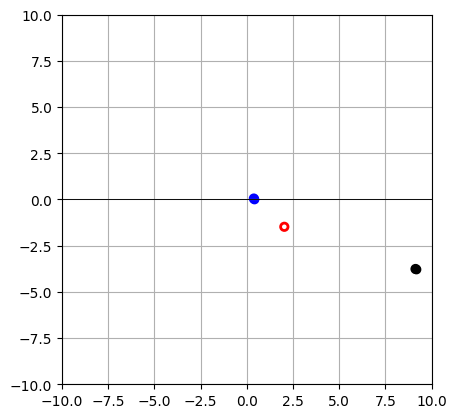

STATE LENGTH 147


(0, array([0.11577179], dtype=float32))

In [49]:
env = Environment()
env.reset()

print("--//--//--//--//--//--//--//--//--//--//--//--//--//--//--//--//" )

print("TARGET COORDINATES", env.target.coordinates)
print("DEFENSE COORDINATES", env.defense.coordinates)
print("ATTACK COORDINATES", env.attack.coordinates)
print("ATTACK MISSILE COORDINATES", env.attack_missile.coordinates)
print("ATTACK MISSILE THETA", env.attack_missile.theta)
print("ATTACK MISSILE SPEED", env.attack_missile.speed)
print("ATTACK MISSILE FIRED", env.attack_missile.fired)
print("DEFENSE MISSILES", env.defense_missiles)
print("INITIAL DEFENSE MISSILE COORDINATES", env.initial_defense_missile.coordinates)
print("INITIAL DEFENSE MISSILE THETA", env.initial_defense_missile.theta)
print("INITIAL DEFENSE MISSILE SPEED", env.initial_defense_missile.speed)
print("INITIAL DEFENSE MISSILE FIRED", env.initial_defense_missile.fired)
print("INITIAL DEFENSE MISSILE FIRED TIME", env.initial_defense_missile.fired_time)
print("INITIAL DEFENSE MISSILE DEFENSE MISSILE TO ATTACK MISSILE", env.initial_defense_missile.defense_missile_to_attack_missile)
print("INITIAL DEFENSE MISSILE START DISTANCE", env.initial_defense_missile.start_distance)
print("INITIAL DEFENSE MISSILE REWARD DIFF", env.initial_defense_missile.reward_diff)
print("ATTACK MISSILE TO TARGET", env.attack_missile_to_target)

env.step((1, 0.5))

# for i in range(50):
#     env.step((0, 0))

# Get the length of the state
state = env.get_state()
print("STATE LENGTH", len(state))

env.action_space.sample()
# env.observation_space.sample()